In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import duckdb

# For plotting
from sklearn.decomposition import PCA


The following dataset is simplified energy balances.

In [2]:
dataset = pd.read_csv('/Users/couch/Eurostat_data/nrg_bal/estat_nrg_bal_c.tsv', sep='\t')
dataset.head()

,"freq,nrg_bal,siec,unit,geo\TIME_PERIOD",1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,"A,AFC,BIOE,GWH,AL",4221.944,4221.944,4221.944,4029.722,3846.389,3671.389,3504.167,3344.722,3192.500,...,2547.175,2728.383,3049.733,2804.720,3129.617,3211.056,3013.181,2963.553,3180.853,3291.735
1,"A,AFC,BIOE,GWH,AT",25744.633,27905.111,27110.141,27367.890,25186.310,27703.651,29117.247,28863.769,27778.728,...,55006.880,57495.297,57863.539,58217.651,55736.679,55563.334,54591.322,61804.231,58790.386,58267.596
2,"A,AFC,BIOE,GWH,BA",:,:,:,:,:,:,:,:,:,...,4618.269,5937.175,5936.294,4843.579,13379.486,13990.576,14750.870,14124.598,15190.525,14556.421
3,"A,AFC,BIOE,GWH,BE",4034.103,4108.185,3958.904,3139.375,3076.269,4344.736,4464.628,4198.739,4792.250,...,24489.936,25304.247,27008.692,27175.362,27777.464,25898.532,27773.760,30037.451,29897.023,29392.697
4,"A,AFC,BIOE,GWH,BG",2005.833,1333.333,1818.057,1656.454,1865.723,2394.221,2724.166,2776.667,4759.722,...,12693.632,13750.594,14423.227,14656.419,16327.377,16722.072,18123.927,17830.582,16818.733,14250.743


In [3]:
dataset.columns

Index(['freq,nrg_bal,siec,unit,geo\TIME_PERIOD', '1990 ', '1991 ', '1992 ',
       '1993 ', '1994 ', '1995 ', '1996 ', '1997 ', '1998 ', '1999 ', '2000 ',
       '2001 ', '2002 ', '2003 ', '2004 ', '2005 ', '2006 ', '2007 ', '2008 ',
       '2009 ', '2010 ', '2011 ', '2012 ', '2013 ', '2014 ', '2015 ', '2016 ',
       '2017 ', '2018 ', '2019 ', '2020 ', '2021 ', '2022 ', '2023 '],
      dtype='object')

In [4]:
# data cleaning
dataset[['freq', 'nrg_bal', 'siec', 'unit', 'geo',]] = dataset['freq,nrg_bal,siec,unit,geo\TIME_PERIOD'].str.split(',', expand=True)
dataset = dataset.drop(columns=['freq,nrg_bal,siec,unit,geo\TIME_PERIOD'])
dataset.columns = dataset.columns.str.strip()
dataset.replace({': ': 0, ': m': np.nan}, inplace=True)
dataset[['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
               '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
               '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
               '2020', '2021', '2022']] = dataset[['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
               '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
               '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
               '2020', '2021', '2022']].apply(pd.to_numeric, errors='coerce')
dataset.columns

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
/var/folders/t3/pjw083nx7_b0p78lsvshw6yc0000gn/T/ipykernel_10122/124697539.py:2: SyntaxWarning: invalid escape sequence '\T'
  dataset[['freq', 'nrg_bal', 'siec', 'unit', 'geo',]] = dataset['freq,nrg_bal,siec,unit,geo\TIME_PERIOD'].str.split(',', expand=True)
/var/folders/t3/pjw083nx7_b0p78lsvshw6yc0000gn/T/ipykernel_10122/124697539.py:3: SyntaxWarning: invalid escape sequence '\T'
  dataset = dataset.drop(columns=['freq,nrg_bal,siec,unit,geo\TIME_PERIOD'])


Index(['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', 'freq',
       'nrg_bal', 'siec', 'unit', 'geo'],
      dtype='object')

In [5]:
dataset.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2019,2020,2021,2022,2023,freq,nrg_bal,siec,unit,geo
0,4221.944,4221.944,4221.944,4029.722,3846.389,3671.389,3504.167,3344.722,3192.500,3046.944,...,3211.056,3013.181,2963.553,3180.853,3291.735,A,AFC,BIOE,GWH,AL
1,25744.633,27905.111,27110.141,27367.890,25186.310,27703.651,29117.247,28863.769,27778.728,31906.583,...,55563.334,54591.322,61804.231,58790.386,58267.596,A,AFC,BIOE,GWH,AT
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,13990.576,14750.870,14124.598,15190.525,14556.421,A,AFC,BIOE,GWH,BA
3,4034.103,4108.185,3958.904,3139.375,3076.269,4344.736,4464.628,4198.739,4792.250,5226.635,...,25898.532,27773.760,30037.451,29897.023,29392.697,A,AFC,BIOE,GWH,BE
4,2005.833,1333.333,1818.057,1656.454,1865.723,2394.221,2724.166,2776.667,4759.722,4900.556,...,16722.072,18123.927,17830.582,16818.733,14250.743,A,AFC,BIOE,GWH,BG


In [6]:
dataset.describe()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,7.249260e+05,7.249260e+05,7.249260e+05,7.249260e+05,7.249260e+05,7.249260e+05,7.249260e+05,7.249260e+05,7.249260e+05,7.249260e+05,...,6.687060e+05,6.546510e+05,6.546510e+05,6.546510e+05,6.546510e+05,6.546510e+05,6.546510e+05,6.685290e+05,6.824070e+05,6.824070e+05
mean,1.223463e+04,1.205404e+04,1.176198e+04,1.167978e+04,1.163122e+04,1.180853e+04,1.212793e+04,1.211809e+04,1.223519e+04,1.200146e+04,...,1.310380e+04,1.307342e+04,1.338146e+04,1.348829e+04,1.373503e+04,1.359490e+04,1.337758e+04,1.147936e+04,1.163087e+04,1.142939e+04
std,3.487346e+05,3.453936e+05,3.390365e+05,3.387564e+05,3.390046e+05,3.459384e+05,3.569021e+05,3.567249e+05,3.622360e+05,3.549369e+05,...,3.595414e+05,3.545126e+05,3.643706e+05,3.664812e+05,3.732409e+05,3.684937e+05,3.635710e+05,3.248169e+05,3.380328e+05,3.344075e+05
min,-8.590264e+05,-8.047337e+05,-9.053598e+05,-8.604821e+05,-9.399470e+05,-1.032500e+06,-1.126137e+06,-1.086897e+06,-1.123770e+06,-1.197101e+06,...,-1.733291e+06,-1.776628e+06,-2.035735e+06,-2.032103e+06,-2.074242e+06,-2.198522e+06,-2.204668e+06,-1.884833e+06,-2.031200e+06,-2.081512e+06
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.237584e+07,6.213000e+07,6.046057e+07,6.039592e+07,6.007045e+07,6.214797e+07,6.425911e+07,6.399223e+07,6.441308e+07,6.382490e+07,...,6.367268e+07,6.148675e+07,6.232384e+07,6.291337e+07,6.424340e+07,6.388166e+07,6.287604e+07,5.773993e+07,6.123207e+07,5.847710e+07


In [7]:
dataset['siec'].unique()

array(['BIOE', 'C0000X0350-0370', 'C0110', 'C0121', 'C0129', 'C0210',
       'C0220', 'C0311', 'C0312', 'C0320', 'C0330', 'C0340', 'C0350',
       'C0350-0370', 'C0360', 'C0371', 'C0379', 'E7000', 'FE', 'G3000',
       'H8000', 'N900H', 'O4000XBIO', 'O4100_TOT', 'O4200', 'O4300',
       'O4400X4410', 'O4500', 'O4610', 'O4620', 'O4630', 'O4640', 'O4651',
       'O4652XR5210B', 'O4653', 'O4661XR5230B', 'O4669', 'O4671XR5220B',
       'O4680', 'O4691', 'O4692', 'O4693', 'O4694', 'O4695', 'O4699',
       'P1000', 'P1100', 'P1200', 'R5110-5150_W6000RI', 'R5160', 'R5210B',
       'R5210P', 'R5220B', 'R5220P', 'R5230B', 'R5230P', 'R5290', 'R5300',
       'RA000', 'RA100', 'RA200', 'RA300', 'RA410', 'RA420', 'RA500',
       'RA600', 'S2000', 'TOTAL', 'W6100', 'W6100_6220', 'W6210', 'W6220'],
      dtype=object)

In [8]:
dataset['geo'].unique()

array(['AL', 'AT', 'BA', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL',
       'ES', 'EU27_2020', 'FI', 'FR', 'GE', 'HR', 'HU', 'IE', 'IS', 'IT',
       'LT', 'LU', 'LV', 'MD', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT',
       'RO', 'RS', 'SE', 'SI', 'SK', 'TR', 'UA', 'UK', 'XK'], dtype=object)

In [9]:
dataset['freq'].unique()

array(['A'], dtype=object)

In [10]:
dataset['nrg_bal'].unique()

array(['AFC', 'DL', 'EXP', 'FC_E', 'FC_IND_CON_E', 'FC_IND_CPC_E',
       'FC_IND_E', 'FC_IND_FBT_E', 'FC_IND_IS_E', 'FC_IND_MAC_E',
       'FC_IND_MQ_E', 'FC_IND_NE', 'FC_IND_NFM_E', 'FC_IND_NMM_E',
       'FC_IND_NSP_E', 'FC_IND_PPP_E', 'FC_IND_TE_E', 'FC_IND_TL_E',
       'FC_IND_WP_E', 'FC_NE', 'FC_OTH_AF_E', 'FC_OTH_CP_E', 'FC_OTH_E',
       'FC_OTH_FISH_E', 'FC_OTH_HH_E', 'FC_OTH_NE', 'FC_OTH_NSP_E',
       'FC_TRA_DAVI_E', 'FC_TRA_DNAVI_E', 'FC_TRA_E', 'FC_TRA_NE',
       'FC_TRA_NSP_E', 'FC_TRA_PIPE_E', 'FC_TRA_RAIL_E', 'FC_TRA_ROAD_E',
       'FEC2020-2030', 'FEC_EED', 'GAE', 'GEP', 'GEP_APCHP', 'GEP_APE',
       'GEP_MAPCHP', 'GEP_MAPE', 'GHP', 'GHP_APCHP', 'GHP_APH',
       'GHP_MAPCHP', 'GHP_MAPH', 'GIC', 'GIC2020-2030', 'GIC_EED', 'IMP',
       'INTAVI', 'INTMARB', 'NRGSUP', 'NRG_BF_E', 'NRG_BIOG_E',
       'NRG_BKBPB_E', 'NRG_CL_E', 'NRG_CM_E', 'NRG_CO_E', 'NRG_CPP_E',
       'NRG_E', 'NRG_EHG_E', 'NRG_GTL_E', 'NRG_GW_E', 'NRG_LNG_E',
       'NRG_NE', 'NRG_NI_E', 'NRG_NSP

In [11]:
dataset.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2019,2020,2021,2022,2023,freq,nrg_bal,siec,unit,geo
0,4221.944,4221.944,4221.944,4029.722,3846.389,3671.389,3504.167,3344.722,3192.500,3046.944,...,3211.056,3013.181,2963.553,3180.853,3291.735,A,AFC,BIOE,GWH,AL
1,25744.633,27905.111,27110.141,27367.890,25186.310,27703.651,29117.247,28863.769,27778.728,31906.583,...,55563.334,54591.322,61804.231,58790.386,58267.596,A,AFC,BIOE,GWH,AT
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,13990.576,14750.870,14124.598,15190.525,14556.421,A,AFC,BIOE,GWH,BA
3,4034.103,4108.185,3958.904,3139.375,3076.269,4344.736,4464.628,4198.739,4792.250,5226.635,...,25898.532,27773.760,30037.451,29897.023,29392.697,A,AFC,BIOE,GWH,BE
4,2005.833,1333.333,1818.057,1656.454,1865.723,2394.221,2724.166,2776.667,4759.722,4900.556,...,16722.072,18123.927,17830.582,16818.733,14250.743,A,AFC,BIOE,GWH,BG


In [12]:
dataset.shape

(1216497, 39)

In [13]:
elec_only = dataset[dataset['siec']=='E7000']
print(elec_only.shape[0])
print(elec_only['nrg_bal'].unique())

16884
['AFC' 'DL' 'EXP' 'FC_E' 'FC_IND_CON_E' 'FC_IND_CPC_E' 'FC_IND_E'
 'FC_IND_FBT_E' 'FC_IND_IS_E' 'FC_IND_MAC_E' 'FC_IND_MQ_E' 'FC_IND_NE'
 'FC_IND_NFM_E' 'FC_IND_NMM_E' 'FC_IND_NSP_E' 'FC_IND_PPP_E' 'FC_IND_TE_E'
 'FC_IND_TL_E' 'FC_IND_WP_E' 'FC_NE' 'FC_OTH_AF_E' 'FC_OTH_CP_E'
 'FC_OTH_E' 'FC_OTH_FISH_E' 'FC_OTH_HH_E' 'FC_OTH_NE' 'FC_OTH_NSP_E'
 'FC_TRA_DAVI_E' 'FC_TRA_DNAVI_E' 'FC_TRA_E' 'FC_TRA_NE' 'FC_TRA_NSP_E'
 'FC_TRA_PIPE_E' 'FC_TRA_RAIL_E' 'FC_TRA_ROAD_E' 'FEC2020-2030' 'FEC_EED'
 'GAE' 'GEP' 'GEP_APCHP' 'GEP_APE' 'GEP_MAPCHP' 'GEP_MAPE' 'GHP'
 'GHP_APCHP' 'GHP_APH' 'GHP_MAPCHP' 'GHP_MAPH' 'GIC' 'GIC2020-2030'
 'GIC_EED' 'IMP' 'INTAVI' 'INTMARB' 'NRGSUP' 'NRG_BF_E' 'NRG_BIOG_E'
 'NRG_BKBPB_E' 'NRG_CL_E' 'NRG_CM_E' 'NRG_CO_E' 'NRG_CPP_E' 'NRG_E'
 'NRG_EHG_E' 'NRG_GTL_E' 'NRG_GW_E' 'NRG_LNG_E' 'NRG_NE' 'NRG_NI_E'
 'NRG_NSP_E' 'NRG_OIL_NG_E' 'NRG_PF_E' 'NRG_PR_E' 'PEC2020-2030' 'PEC_EED'
 'PPRD' 'RCV_RCY' 'STATDIFF' 'STK_CHG' 'TI_BF_E' 'TI_BKBPB_E' 'TI_BNG_E'
 'TI_CL_E' 'TI_C

In [14]:
elec_total_output = elec_only[elec_only['nrg_bal']=='TO_EHG']
elec_total_output

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2019,2020,2021,2022,2023,freq,nrg_bal,siec,unit,geo
1019136,3296.000,3818.000,3394.000,3529.000,3941.000,4473.000,5982.000,5228.000,5109.000,5429.000,...,5206.043,5313.166,8962.710,7002.643,9006.016,A,TO_EHG,E7000,GWH,AL
1019137,50294.472,51483.467,51190.686,52419.655,53132.219,56225.421,54879.675,56704.937,57001.948,60944.018,...,74234.304,72558.156,70886.543,69193.236,74459.414,A,TO_EHG,E7000,GWH,AT
1019138,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,17493.000,16874.000,18536.000,16381.000,17185.000,A,TO_EHG,E7000,GWH,BA
1019139,70923.000,71936.000,72225.000,70834.000,72179.000,74408.000,76099.000,78833.000,83183.000,84514.000,...,93644.295,89453.591,100481.600,95947.800,83669.400,A,TO_EHG,E7000,GWH,BE
1019140,42141.000,40862.000,35610.000,37997.000,38133.000,41789.000,42716.000,42803.000,41711.000,38248.000,...,44276.591,40754.441,47568.096,50499.304,40255.508,A,TO_EHG,E7000,GWH,BG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019254,94075.200,89089.200,85057.200,87991.200,92563.801,96387.602,92736.601,91249.200,93715.200,102265.200,...,102362.400,103816.800,108057.600,96616.800,107650.800,A,TO_EHG,E7000,TJ,SK
1019255,207154.800,216885.600,242431.200,265708.800,281955.600,310489.200,341503.200,371865.600,399679.200,419184.000,...,1094031.216,1104131.135,1205003.196,1182165.628,1192136.022,A,TO_EHG,E7000,TJ,TR
1019256,1075806.000,1003258.800,909086.400,827661.600,730519.200,698464.800,658749.600,640807.200,622159.200,619632.000,...,554907.600,534268.440,0.000,0.000,0,A,TO_EHG,E7000,TJ,UA
1019257,1151053.200,1162350.000,1155754.800,1163167.200,1175353.200,1202547.600,1263128.400,1262397.600,1305730.800,1325347.200,...,1164354.368,0.000,0.000,0.000,0,A,TO_EHG,E7000,TJ,UK


In [15]:
elec_total_output.columns

Index(['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', 'freq',
       'nrg_bal', 'siec', 'unit', 'geo'],
      dtype='object')

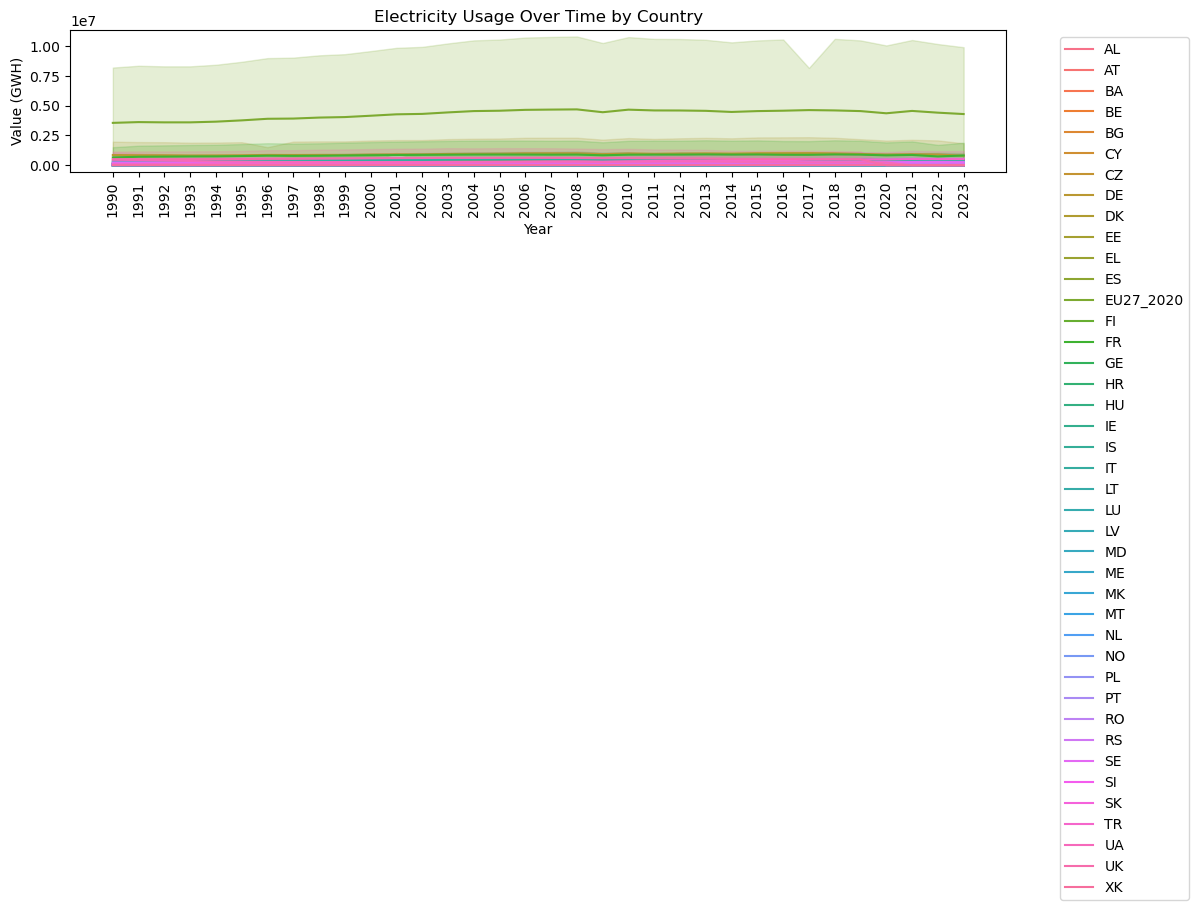

In [16]:
# Experimental plots
year_cols = [str(year) for year in range(1990, 2024)]  # or whatever range is available

long_df = elec_total_output.melt(
    id_vars=['geo', 'unit'],  # optionally keep 'siec' or 'nrg_bal' if you need
    value_vars=year_cols,
    var_name='year',
    value_name='value'
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=long_df, x='year', y='value', hue='geo')
plt.title('Electricity Usage Over Time by Country')
plt.ylabel(f'Value ({long_df["unit"].unique()[0]})')
plt.gca().invert_yaxis()
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

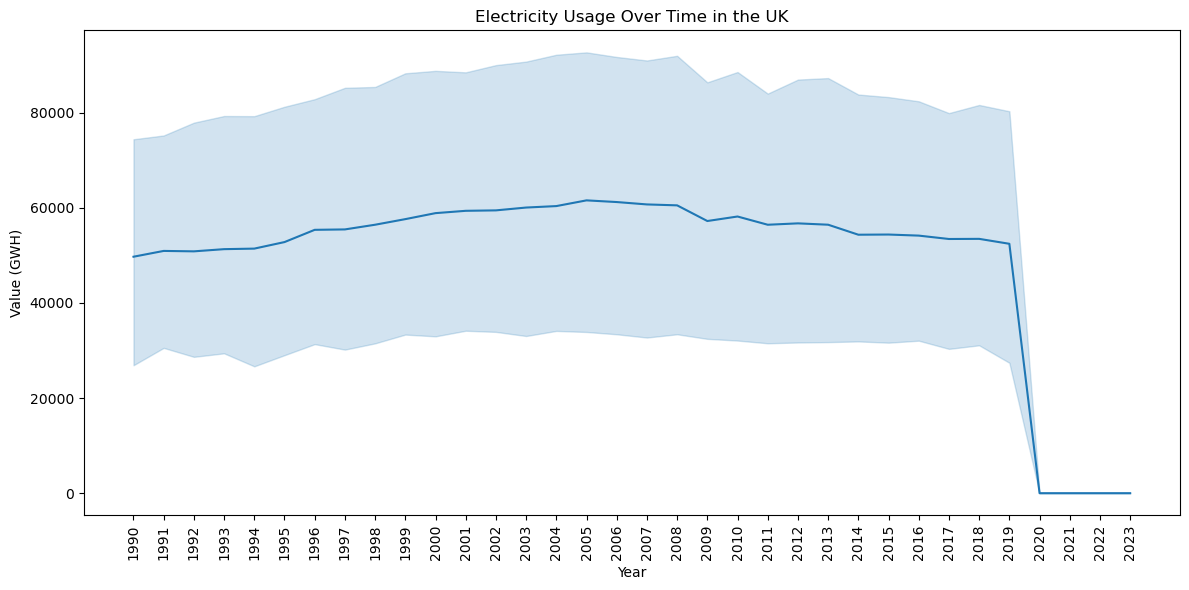

In [17]:
# Note: This dataset was only for the EU. Since Brexit, the UK is no longer part of the EU, it has values of 0 after
# a certain point.
UK_only = dataset[(dataset['geo']=='UK') & (dataset['siec']=='E7000')]
UK_only_long = UK_only.melt(
    id_vars=['geo', 'unit'],
    value_vars=year_cols,
    var_name='year',
    value_name='value'
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=UK_only_long, x='year', y='value')
plt.title('Electricity Usage Over Time in the UK')
plt.ylabel(f'Value ({UK_only_long["unit"].unique()[0]})')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [18]:
BE_only = dataset[(dataset['geo']=='BE') & (dataset['siec']=='E7000')]
BE_only_long = BE_only.melt(
    id_vars=['geo', 'unit'],
    value_vars=year_cols,
    var_name='year',
    value_name='value'
)
BE_only_long

,geo,unit,year,value
0,BE,GWH,1990,57984.0
1,BE,KTOE,1990,4985.727
2,BE,TJ,1990,208742.4
3,BE,GWH,1990,3604.0
4,BE,KTOE,1990,309.888
...,...,...,...,...
14173,BE,KTOE,2023,NaN
14174,BE,TJ,2023,NaN
14175,BE,GWH,2023,NaN
14176,BE,KTOE,2023,NaN


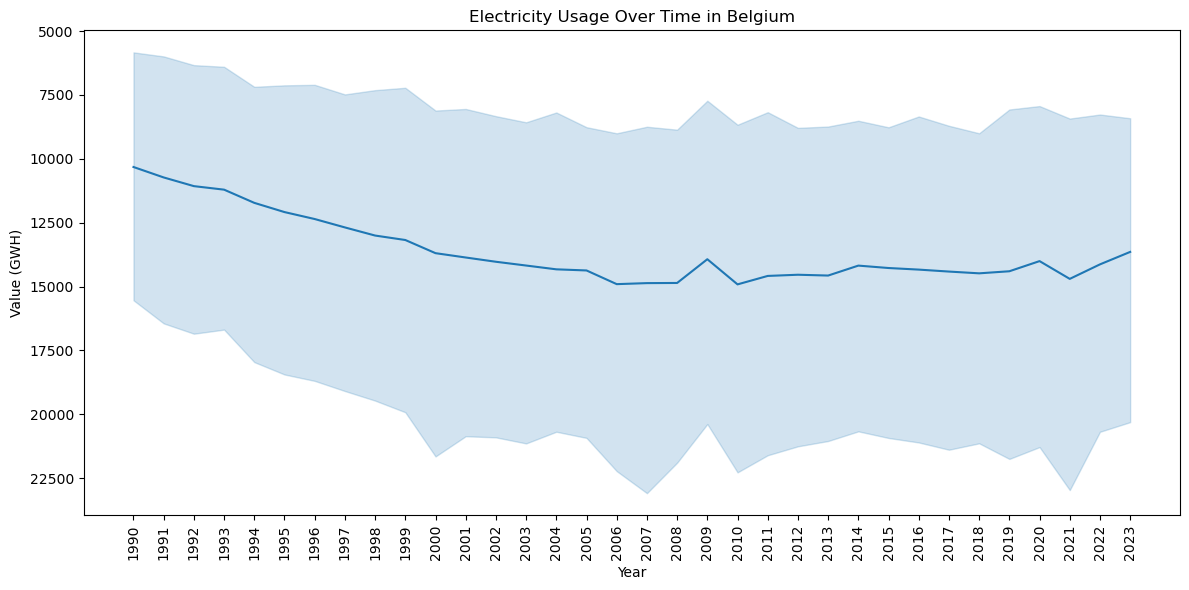

In [19]:
BE_only = dataset[(dataset['geo']=='BE') & (dataset['siec']=='E7000')]
BE_only_long = BE_only.melt(
    id_vars=['geo', 'unit'],
    value_vars=year_cols,
    var_name='year',
    value_name='value'
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=BE_only_long, x='year', y='value')
plt.title('Electricity Usage Over Time in Belgium')
plt.ylabel(f'Value ({BE_only_long["unit"].unique()[0]})')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

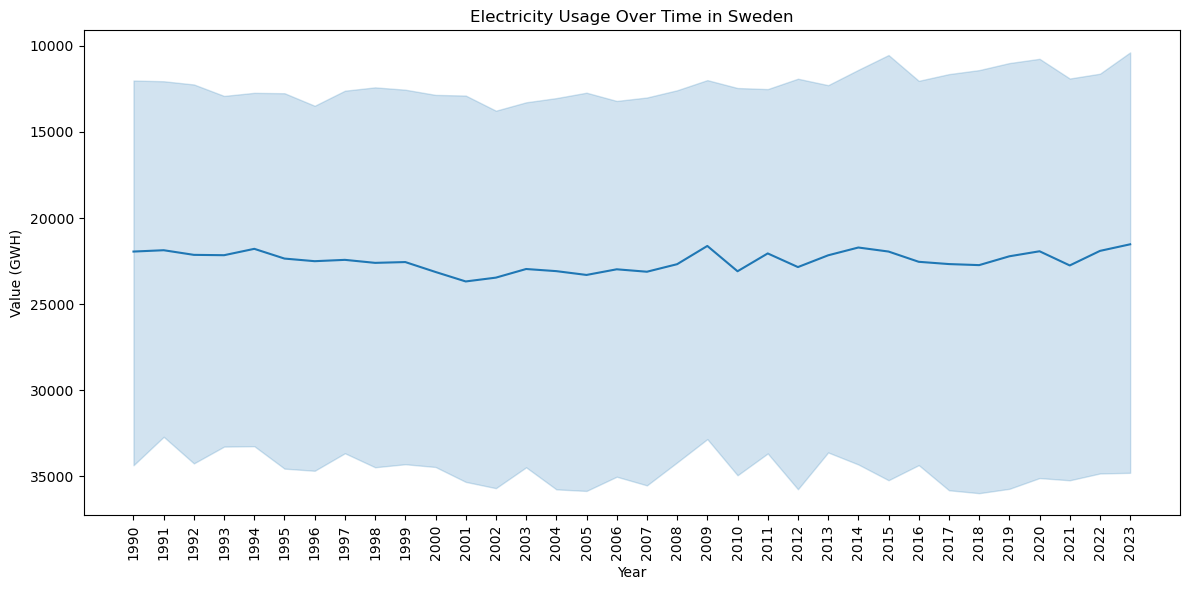

In [20]:
sweden_only = dataset[(dataset['geo']=='SE') & (dataset['siec']=='E7000')]
sweden_only_long = sweden_only.melt(
    id_vars=['geo', 'unit'],
    value_vars=year_cols,
    var_name='year',
    value_name='value'
)
plt.figure(figsize=(12, 6))
sns.lineplot(data=sweden_only_long, x='year', y='value')
plt.title('Electricity Usage Over Time in Sweden')
plt.ylabel(f'Value ({sweden_only_long["unit"].unique()[0]})')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


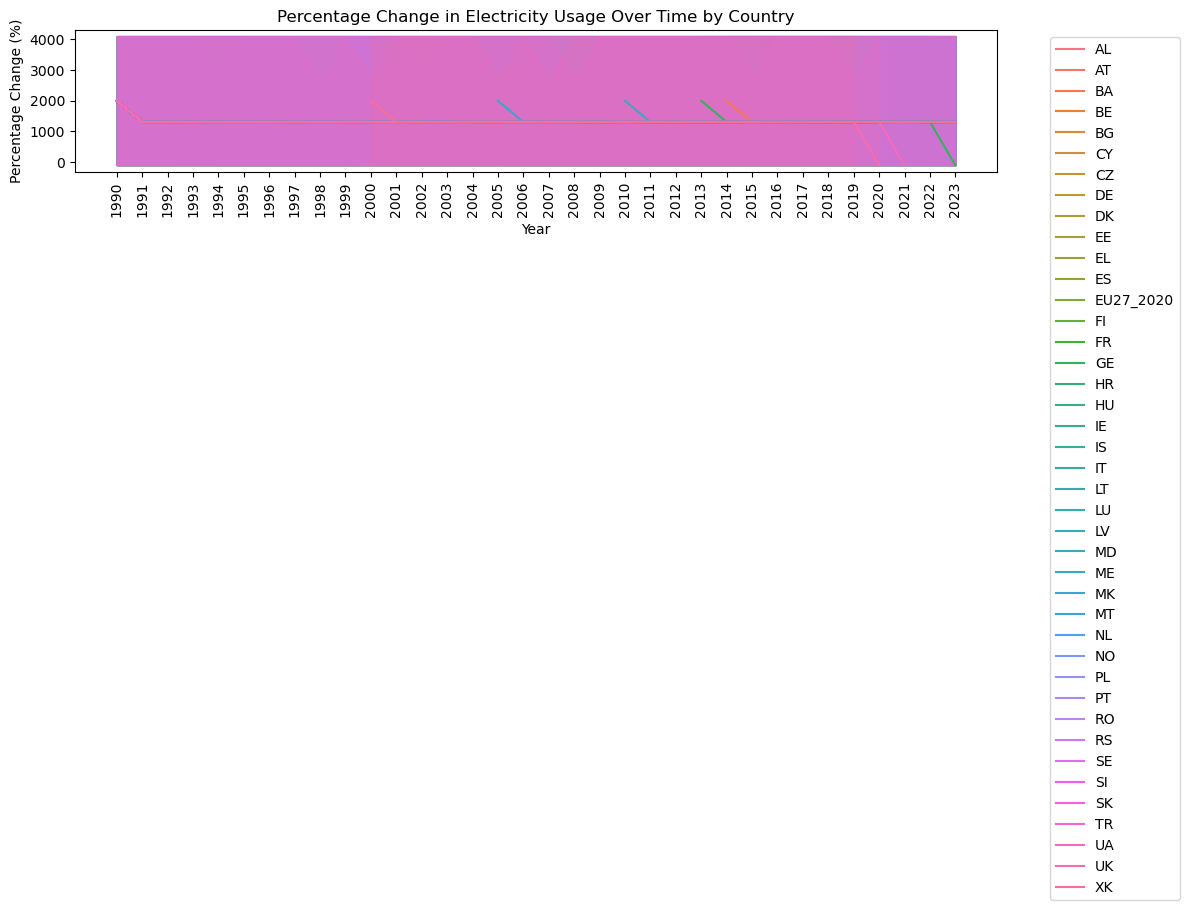

In [21]:
# Supposed to be countries by change in percentage of electricity usage per year but kind of mid graph tbh
long_df['value'] = pd.to_numeric(long_df['value'], errors='coerce')
long_df = long_df.sort_values(['geo', 'year'])
long_df['pct_change'] = long_df.groupby('geo')['value'].pct_change() * 100
plt.figure(figsize=(12, 6))
sns.lineplot(data=long_df, x='year', y='pct_change', hue='geo')
plt.title('Percentage Change in Electricity Usage Over Time by Country')
plt.ylabel('Percentage Change (%)')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [22]:
# First, aggregate total electricity usage per country-year
agg_df = long_df.groupby(['geo', 'year'], as_index=False)['value'].sum()

# Pivot: countries as rows, years as columns
country_year_matrix = agg_df.pivot(index='geo', columns='year', values='value')

# Optional: fill missing values (e.g., with 0 or interpolation)
country_year_matrix = country_year_matrix.fillna(0)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
country_year_scaled = scaler.fit_transform(country_year_matrix)

# Keep row labels (country names)
country_year_scaled_df = pd.DataFrame(country_year_scaled, index=country_year_matrix.index, columns=country_year_matrix.columns)

from sklearn.cluster import KMeans

# Choose number of clusters (e.g., 3–5 is a good start)
kmeans = KMeans(n_clusters=4, random_state=42)
country_clusters = kmeans.fit_predict(country_year_scaled)

# Add cluster labels to a new column
country_year_matrix['cluster'] = country_clusters


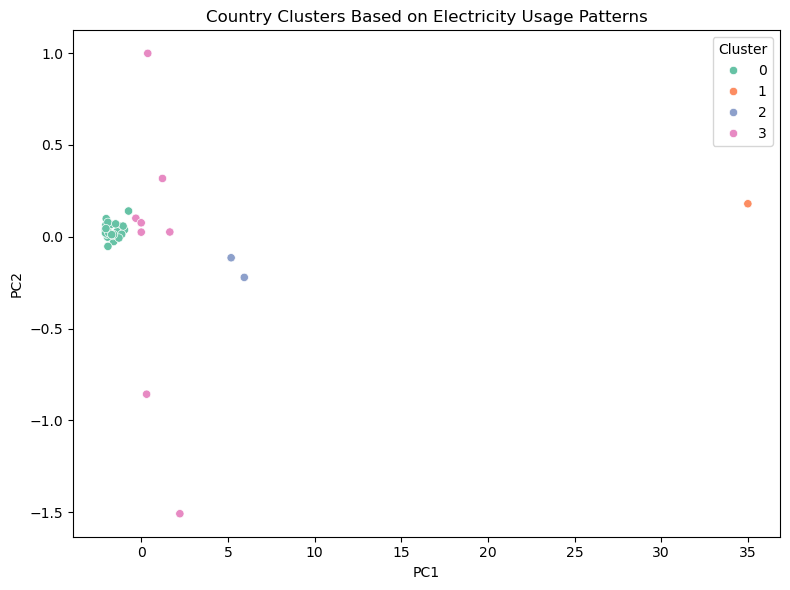

In [23]:
# Performing PCA to cluster countries based on their electricity usage patterns
pca = PCA(n_components=2)
coords = pca.fit_transform(country_year_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=country_clusters, palette='Set2')
plt.title('Country Clusters Based on Electricity Usage Patterns')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


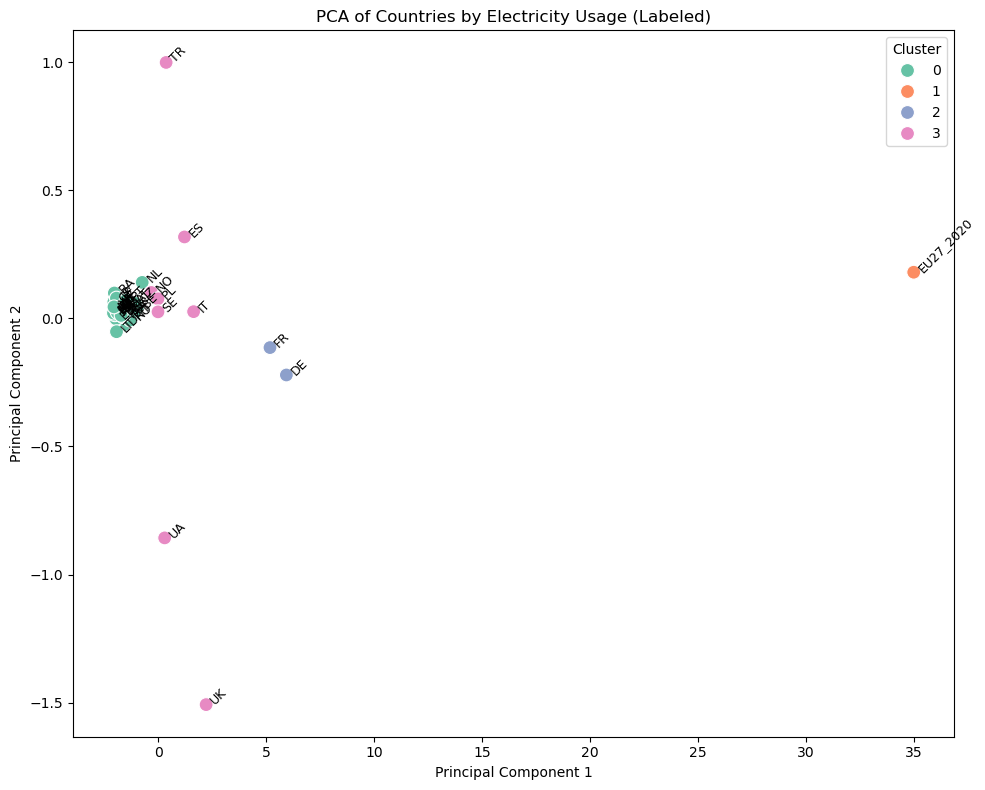

In [24]:
# PCA but labelled
pca = PCA(n_components=2)
coords = pca.fit_transform(country_year_scaled)

# Turn into DataFrame with country names and cluster labels
pca_df = pd.DataFrame({
    'PC1': coords[:, 0],
    'PC2': coords[:, 1],
    'country': country_year_matrix.index,
    'cluster': country_clusters
})

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='Set2', s=100)

for _, row in pca_df.iterrows():
    plt.text(
        row['PC1'] + 0.1,
        row['PC2'],
        row['country'],
        fontsize=9,
        rotation=45  
    )

plt.title('PCA of Countries by Electricity Usage (Labeled)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [25]:
# List of countries by cluster
cluster_groups = pca_df.groupby('cluster')['country'].apply(list)

print(cluster_groups)


cluster
0    [AL, AT, BA, BE, BG, CY, CZ, DK, EE, EL, FI, G...
1                                          [EU27_2020]
2                                             [DE, FR]
3                     [ES, IT, NO, PL, SE, TR, UA, UK]
Name: country, dtype: object


In [28]:
print(cluster_groups[0])

['AL', 'AT', 'BA', 'BE', 'BG', 'CY', 'CZ', 'DK', 'EE', 'EL', 'FI', 'GE', 'HR', 'HU', 'IE', 'IS', 'LT', 'LU', 'LV', 'MD', 'ME', 'MK', 'MT', 'NL', 'PT', 'RO', 'RS', 'SI', 'SK', 'XK']
